# Fine-Tuning LLaVA on Astronomical Data

In this notebook, we fine tune LLaVA (Large Language and Vision Assistant), a multimodal VLM (vision-language model) to be better adapted to describing astronomical images.

## **0. Basic Setup**

I'll assume this notebook is running on **Google colab**.

If so, we need to install some packages before we proceed. After the below cell runs, **restart the kernel** to be sure the notebook has access to these packages.

In [1]:
!pip install -q bitsandbytes
!pip install -q peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.4 MB/s eta 0:00:00


In [2]:
import requests
import json
import os
from pathlib import Path
from PIL import Image
import time
from typing import Dict, List, Any
from datetime import datetime, timedelta
import random

import torch
from torch.utils.data import Dataset
from transformers import AutoProcessor, LlavaForConditionalGeneration, TrainingArguments, Trainer

## **1. Dataset Creation**

LLaVA is trained on image and image caption pairs. As such, we need a similar data structure to train it with.

High quality image captions that contain real astronomical descriptions are ideal. For the purposes of this tutorial, we'll grab a *small but high quality* dataset from NASA sources. While not ideal for real, quality fine tuning, it should be sufficient to see some basic changes in the model.

---

#### **The Data Source**: NASA Astronomy Picture of the Day (APOD)
- **What it is**: Daily astronomical images with professional explanations
- **Typical length**: 100-300 words of detailed scientific explanation
- **Coverage**: Diverse astronomical phenomena (galaxies, nebulae, planets, etc.)

### **Create Dataset Collector**

We'll scrape this data using NASA's APIs. The dataset collector can be found in `nasa_dataset_collector.py`.
This code will:

- Handle image downloading and validation  
- Scrape descriptions
- Preserve metadata and attributions

#### `nasa_dataset_collector.py`

The below code contains our dataset collector. You can look at it more closely, or just run the cell to create the .py file and proceed again.

It scrapes data from NASA APOD, which is necessary for this tutorial, but not strictly necessary code for a generalized LLaVA training, so we won't discuss it in detail.

In [3]:
%%writefile nasa_dataset_collector.py

"""print
NASA Data Collector - Pure Data Collection Only
==============================================

This module collects authentic astronomical data from NASA's APIs.
It downloads and saves the raw data for later formatting for specific models.

Key Features:
- NASA APOD (Astronomy Picture of the Day) collection
- Image downloading and validation
- Raw JSON data preservation
- Astronomical descriptions
"""

import requests
import json
from pathlib import Path
from PIL import Image
import time
from datetime import datetime, timedelta
import random

class NASADataCollector:
    """
    Collects astronomical data from NASA APIs

    This class focuses purely on data collection - downloading images
    and preserving the original NASA descriptions exactly as provided.
    No model-specific formatting is done here.
    """

    def __init__(self, api_key: str = "DEMO_KEY", output_dir: str = "real_nasa_dataset"):
        """
        Initialize the NASA data collector

        Args:
            api_key (str): NASA API key. Get free key at https://api.nasa.gov/
                          DEMO_KEY allows 30 requests/hour
                          Personal keys allow 1,000 requests/hour
            output_dir (str): Directory where data and images will be saved
        """
        self.api_key = api_key
        self.output_dir = Path(output_dir)
        self.images_dir = self.output_dir / "images"

        # Create directories if they don't exist
        self.output_dir.mkdir(exist_ok=True)
        self.images_dir.mkdir(exist_ok=True)

        # HTTP headers for respectful API usage
        self.headers = {
            'User-Agent': 'Educational Workshop NASA Data Collection'
        }

        # Storage for collected data
        self.dataset = []

        # Startup info
        print(f"🚀 NASA Data Collector initialized")
        print(f"API Key: {'DEMO_KEY (30 req/hr)' if api_key == 'DEMO_KEY' else 'Personal key'}")
        print(f"Output: {self.output_dir}")

    def collect_apod_data(self, num_examples: int = 15):
        """
        Collect NASA Astronomy Picture of the Day data

        APOD provides daily astronomical images with detailed explanations
        written by professional astronomers. This is our primary data source
        because the descriptions are:
        - High-quality
        - Educational (designed to explain complex concepts)
        - Diverse (covers all areas of astronomy)

        Args:
            num_examples (int): Number of APOD entries to collect
        """
        print(f"\n🌌 Collecting NASA APOD Data")
        print("=" * 50)
        print()

        # Generate random dates from past 3 years to get diverse content
        # We use random dates rather than recent dates to ensure variety
        # in astronomical phenomena (different seasons, events, etc.)
        date_list = self._generate_random_dates(num_examples)

        successful_downloads = 0

        # Process each date
        for i, date in enumerate(date_list):
            try:
                print(f"📅 Fetching APOD for {date}...")

                # Make API request to NASA's APOD service
                data = self._fetch_apod_for_date(date)

                # Apply quality filters to ensure we get good training data
                if not self._passes_quality_filters(data, date):
                    continue

                # Download the astronomical image
                filename = self._create_safe_filename(data, i + 1, date)
                if not self._download_and_validate_image(data, filename):
                    print(f"  ❌ Image download failed")
                    continue

                # Store the raw NASA data exactly as provided
                self.dataset.append({
                    # File information
                    "image_path": f"images/{filename}",
                    "date": data['date'],

                    # Original NASA content (preserved exactly)
                    "title": data['title'],
                    "description": data['explanation'],  # This is the key training data
                    "copyright": data.get('copyright', 'NASA (Public Domain)'),

                    # Metadata for analysis
                    "source": "NASA APOD API",
                    "word_count": len(data['explanation'].split()),
                    "image_url": data.get('hdurl') or data.get('url')
                })

                successful_downloads += 1
                word_count = len(data['explanation'].split())

                # Show progress with key info
                print(f"  ✅ Success! ({word_count} words)")
                print(f"     Preview: {data['explanation'][:80]}...")
                print()

                # Be respectful to NASA's servers (1 second between requests)
                time.sleep(1)

            except Exception as e:
                print(f"  ❌ Error processing {date}: {e}")
                continue

    def _generate_random_dates(self, num_examples: int) -> list:
        """
        Generate random dates from the past 3 years for content diversity

        Args:
            num_examples (int): Number of dates to generate

        Returns:
            list: List of date strings in YYYY-MM-DD format
        """
        base_date = datetime.now()
        date_list = []

        for _ in range(num_examples):
            # Random date within last 3 years (1095 days)
            days_back = random.randint(1, 1095)
            random_date = base_date - timedelta(days=days_back)
            date_list.append(random_date.strftime('%Y-%m-%d'))

        return date_list

    def _fetch_apod_for_date(self, date: str) -> dict:
        """
        Fetch APOD data for a specific date from NASA API

        Args:
            date (str): Date in YYYY-MM-DD format

        Returns:
            dict: JSON response from NASA APOD API

        Raises:
            requests.RequestException: If API request fails
        """
        url = "https://api.nasa.gov/planetary/apod"
        params = {
            'api_key': self.api_key,
            'date': date,
            'hd': True  # Request high-resolution images when available
        }

        response = requests.get(url, params=params, headers=self.headers, timeout=30)
        response.raise_for_status()
        return response.json()

    def _passes_quality_filters(self, data: dict, date: str) -> bool:
        """
        Apply quality filters to ensure we get good training data

        We only want:
        - Images (not videos)
        - Content with explanations (our training text)
        - Explanations with sufficient length

        Args:
            data (dict): APOD data from NASA API
            date (str): Date string for logging

        Returns:
            bool: True if data passes all quality filters
        """
        # Filter 1: Only process images, skip videos
        if data.get('media_type') != 'image':
            print(f"  ⚠️  Skipping {date} - video content")
            return False

        # Filter 2: Must have an explanation (this is our training text)
        explanation = data.get('explanation', '')
        if not explanation:
            print(f"  ⚠️  Skipping {date} - no explanation")
            return False

        # Filter 3: Explanation must be substantial (at least 30 words)
        # Short explanations don't provide enough context for training
        if len(explanation.split()) < 30:
            print(f"  ⚠️  Skipping {date} - explanation too short")
            return False

        # Filter 4: Must have an image URL
        image_url = data.get('hdurl') or data.get('url')
        if not image_url:
            print(f"  ⚠️  Skipping {date} - no image URL")
            return False

        return True

    def _create_safe_filename(self, data: dict, index: int, date: str) -> str:
        """
        Create a safe filename for the downloaded image

        Args:
            data (dict): APOD data containing title
            index (int): Sequential number for this download
            date (str): Date string

        Returns:
            str: Safe filename for the image
        """
        # Clean title to make it filesystem-safe
        title = data.get('title', 'untitled')
        safe_title = "".join(c for c in title if c.isalnum() or c in (' ', '-', '_')).strip()

        # Create descriptive filename with index, date, and title
        filename = f"nasa_{index:02d}_{date}_{safe_title[:25]}.jpg"
        return filename

    def _download_and_validate_image(self, data: dict, filename: str) -> bool:
        """
        Download astronomical image and validate it's usable

        Args:
            data (dict): APOD data containing image URL
            filename (str): Local filename to save as

        Returns:
            bool: True if download and validation successful
        """
        try:
            # Get image URL (prefer HD version)
            image_url = data.get('hdurl') or data.get('url')

            print(f"    Downloading image...")

            # Download image with streaming to handle large files
            response = requests.get(image_url, headers=self.headers, timeout=30, stream=True)
            response.raise_for_status()

            # Save image to disk
            image_path = self.images_dir / filename
            with open(image_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)

            # Validate the image is readable and convert to standard format
            return self._validate_and_convert_image(image_path)

        except Exception as e:
            print(f"    Download failed: {e}")
            return False

    def _validate_and_convert_image(self, image_path: Path) -> bool:
        """
        Validate downloaded image and convert to standard RGB JPEG format

        Args:
            image_path (Path): Path to downloaded image

        Returns:
            bool: True if image is valid and converted successfully
        """
        try:
            with Image.open(image_path) as img:
                width, height = img.size

                # Convert to RGB if needed (handles PNG, GIF, etc.)
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                    img.save(image_path.with_suffix('.jpg'), 'JPEG', quality=85)

                    # Rename file if extension changed
                    if image_path.suffix != '.jpg':
                        new_path = image_path.with_suffix('.jpg')
                        image_path.rename(new_path)

                print(f"    ✅ Image validated: {width}x{height} pixels")
                return True

        except Exception as e:
            print(f"    ❌ Image validation failed: {e}")
            # Clean up invalid image file
            if image_path.exists():
                image_path.unlink()
            return False

    def save_dataset(self, filename: str = "nasa_data.json") -> Path:
        """
        Save collected dataset to JSON file

        The saved dataset contains raw NASA data exactly as collected,
        with no model-specific formatting applied.

        Args:
            filename (str): Name of output JSON file

        Returns:
            Path: Path to saved dataset file
        """
        output_path = self.output_dir / filename

        # Save with pretty formatting for human readability
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(self.dataset, f, indent=2, ensure_ascii=False)

        print(f"\n💾 Dataset saved to: {output_path}")
        print(f"📁 Images saved in: {self.images_dir}")

        return output_path

    def print_dataset_report(self):
        """
        Print comprehensive report about the collected dataset

        This helps assess data quality and suitability for training
        """
        if not self.dataset:
            print("❌ No data collected!")
            return

        total_examples = len(self.dataset)
        total_words = sum(item['word_count'] for item in self.dataset)
        avg_words = total_words / total_examples

        print(f"\n📈 DATASET REPORT")
        print("=" * 40)
        print(f"📊 Examples collected: {total_examples}")
        print(f"📝 Total words: {total_words:,}")
        print(f"📏 Average words per description: {avg_words:.0f}")
        print()

        # Show sample to demonstrate quality
        if self.dataset:
            sample = self.dataset[0]
            print(f"📋 Sample Entry:")
            print(f"   Words: {sample['word_count']}")
            print(f"   Preview: {sample['description'][:120]}...")
            print()


    def collect_data(self, num_examples: int = 15) -> dict:
        """
        Main function to collect NASA data and save it

        This is the primary interface for data collection.
        Call this to get a complete dataset ready for training.

        Args:
            num_examples (int): Number of examples to collect

        Returns:
            dict: Summary information about collected dataset
        """
        # Collect the data
        self.collect_apod_data(num_examples)

        # Save to file
        dataset_path = self.save_dataset()

        # Generate report
        self.print_dataset_report()

        print(f"\n🎉 DATA COLLECTION COMPLETE!")

        return {
            "dataset_path": str(dataset_path),
            "images_dir": str(self.images_dir),
            "total_examples": len(self.dataset),
            "average_words": sum(item['word_count'] for item in self.dataset) / len(self.dataset) if self.dataset else 0,
        }

# Convenience function for easy use in notebooks
def collect_nasa_data(api_key: str = "DEMO_KEY", num_examples: int = 15) -> dict:
    """
    Simple function to collect NASA astronomical data

    This is the main function you'll use in your notebook.
    It handles all the complexity of data collection internally.

    Args:
        api_key (str): NASA API key (get free at https://api.nasa.gov/)
        num_examples (int): Number of examples to collect

    Returns:
        dict: Information about the collected dataset
    """
    collector = NASADataCollector(api_key=api_key)
    return collector.collect_data(num_examples=num_examples)

Writing nasa_dataset_collector.py


### **Run the Collector**
To run this collector, we'll import the main functionality from the .py file and run it here:

> Note, below we use a `DEMO_KEY` for this tutorial, but you can get your own free API key:
>
> 1. Visit: https://api.nasa.gov/
> 2. Click "Generate API Key"
> 3. Fill out the simple form (2 minutes)
> 4. Check your email for the key
> 5. Replace `"DEMO_KEY"` with your actual key
>
> The DEMO_KEY allows 30 requests/hour (ok for what we download here), but a personal key allows up to 1,000 requests/hour

**🚨 Important**: This step downloads real images and may take 2-3 minutes depending on your internet connection.

In [4]:
# Import our NASA data collection module
from nasa_dataset_collector import collect_nasa_data

# Collect 15 examples of NASA APOD data
print("🚀 Collecting Real NASA Astronomical Data")
print("=" * 50)

dataset_info = collect_nasa_data(
    api_key="DEMO_KEY",  # Get your free key at https://api.nasa.gov/
    num_examples=15
)

print(f"\n✅ Collection Complete!")
print(f"Examples collected: {dataset_info['total_examples']}")
print(f"Average description length: {dataset_info['average_words']:.0f} words")

🚀 Collecting Real NASA Astronomical Data
🚀 NASA Data Collector initialized
API Key: DEMO_KEY (30 req/hr)
Output: real_nasa_dataset

🌌 Collecting NASA APOD Data

📅 Fetching APOD for 2023-06-28...
    ✅ Image validated: 1500x1011 pixels
  ✅ Success! (138 words)
     Preview: Unlike most entries in Charles Messier's famous catalog of deep sky objects, M24...

📅 Fetching APOD for 2024-03-18...
    ✅ Image validated: 2564x1603 pixels
  ✅ Success! (200 words)
     Preview: A bright comet will be visible during next month's total solar eclipse.  This ve...

📅 Fetching APOD for 2024-02-02...
    ✅ Image validated: 2048x1347 pixels
  ✅ Success! (152 words)
     Preview: This cosmic view shows off an otherwise faint emission nebula IC 410, captured u...

📅 Fetching APOD for 2023-11-18...
    ✅ Image validated: 1280x720 pixels
  ✅ Success! (168 words)
     Preview: One year ago a Space Launch System rocket left planet Earth on November 16, 2022...

📅 Fetching APOD for 2023-05-21...
    ✅ Image va

After running this data collection, you should have:

```
real_nasa_dataset/
├── real_nasa_data.json          # Dataset with all metadata
├── images/                      # Downloaded astronomical images
│   ├── apod_01_2024-01-15_*.jpg
│   ├── apod_02_2024-02-22_*.jpg
│   └── ...
```

Each entry in `real_nasa_data.json` contains:
- `image_path`: Path to the astronomical image
- `title`: Original NASA title
- `description`: NASA's image explanation written by astronomers
- `source`: "NASA APOD API"
- `word_count`: Length of description
- `date`: When the image was featured
- `copyright`: Attribution information


### **Inspect Downloaded Data**

Now, let's look aat a few of the examples in our newly-downloaded dataset.

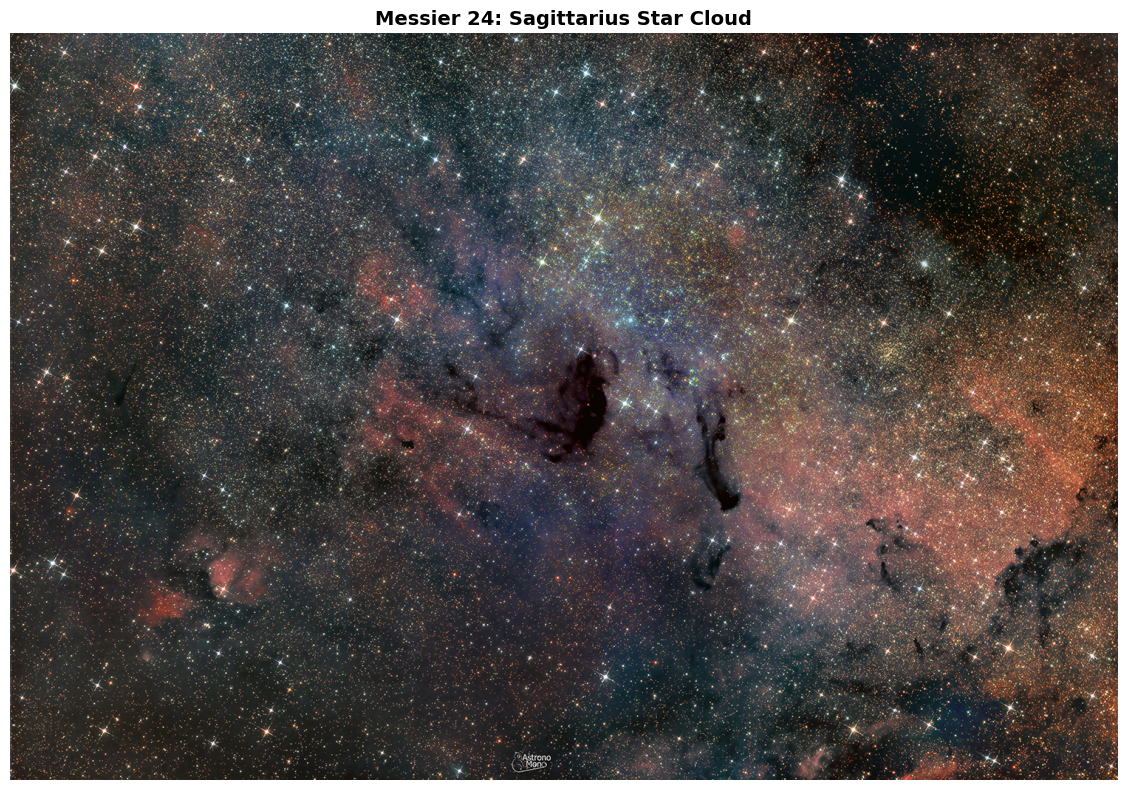

Title: Messier 24: Sagittarius Star Cloud
Date: 2023-06-28
Source: NASA APOD API
Words: 138

Description:
Unlike most entries in Charles Messier's famous catalog of deep sky objects, M24 is not a bright galaxy, star cluster, or nebula. It's a gap in nearby, obscuring interstellar dust clouds that allows a view of the distant stars in the Sagittarius spiral arm of our Milky Way galaxy. Direct your gaze through this gap with binoculars or small telescope and you are looking through a window over 300 light-years wide at stars some 10,000 light-years or more from Earth. Sometimes called the Small Sagittarius Star Cloud, M24's luminous stars fill this gorgeous starscape.  Covering over 3 degrees or the width of 6 full moons in the constellation Sagittarius, the telescopic field of view includes dark markings B92 and B93 near center, along with other clouds of dust and glowing nebulae toward the center of the Milky Way.




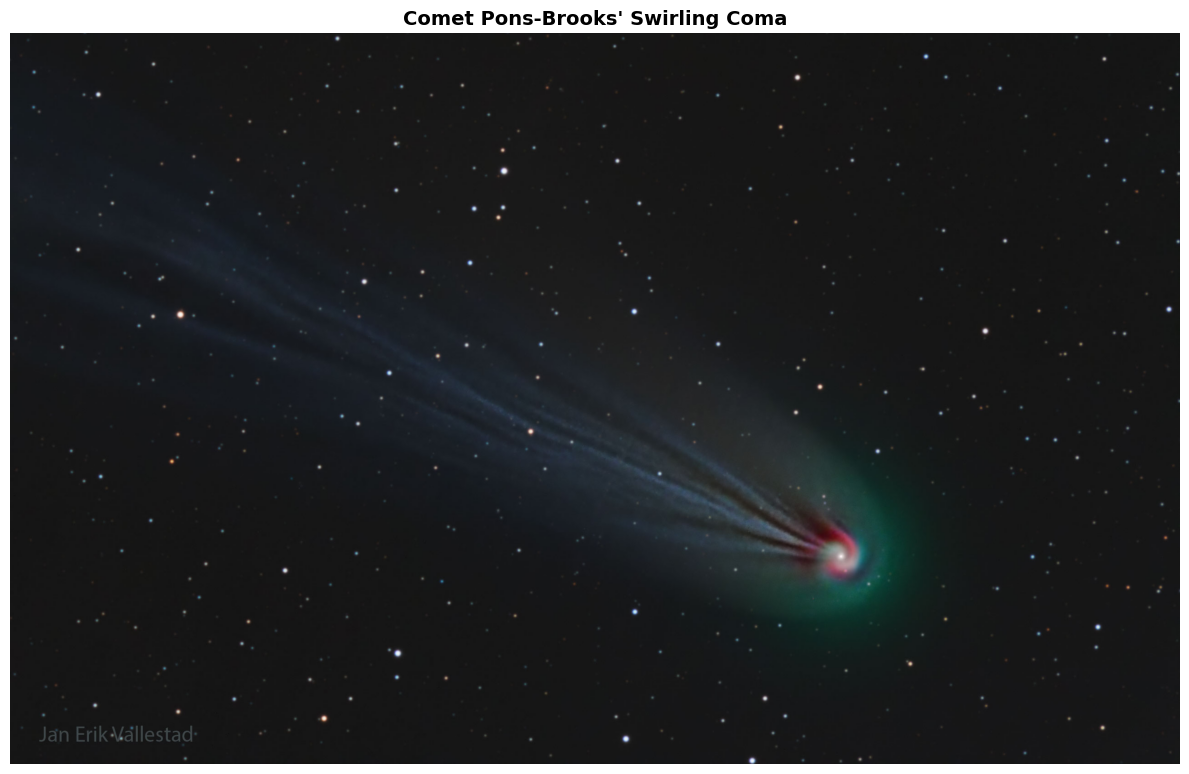

Title: Comet Pons-Brooks' Swirling Coma
Date: 2024-03-18
Source: NASA APOD API
Words: 200

Description:
A bright comet will be visible during next month's total solar eclipse.  This very unusual coincidence occurs because Comet 12P/Pons-Brooks's return to the inner Solar System places it by chance only 25 degrees away from the Sun during Earth's April 8 total solar eclipse.  Currently the comet is just on the edge of visibility to the unaided eye, best visible with binoculars in the early evening sky toward the constellation of the Fish (Pisces). Comet Pons-Brooks, though, is putting on quite a show for deep camera images even now.  The featured image is a composite of three very specific colors, showing the comet's ever-changing ion tail in light blue, its outer coma in green, and highlights some red-glowing gas around the coma in a spiral. The spiral is thought to be caused by gas being expelled by the slowly rotating nucleus of the giant iceberg comet. Although it is always difficul

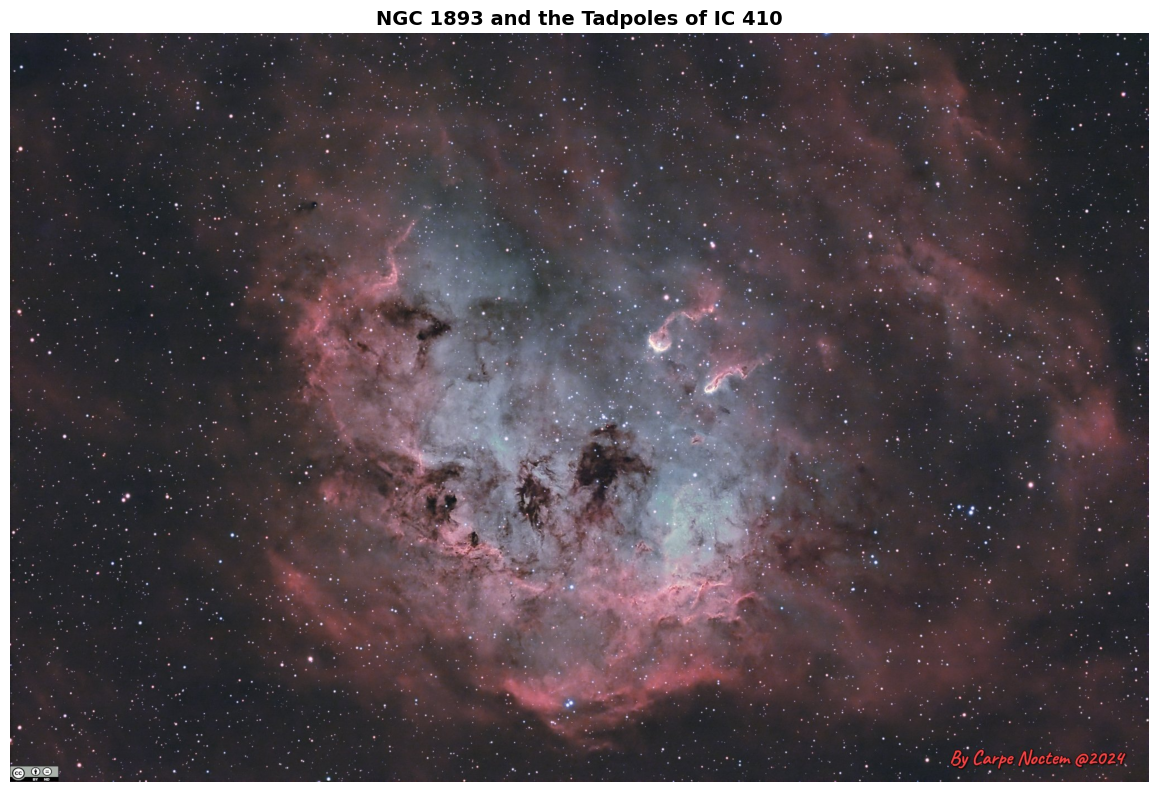

Title: NGC 1893 and the Tadpoles of IC 410
Date: 2024-02-02
Source: NASA APOD API
Words: 152

Description:
This cosmic view shows off an otherwise faint emission nebula IC 410, captured under clear Netherlands skies with telescope and narrowband filters. Above and right of center you can spot two remarkable inhabitants of the interstellar pond of gas and dust, known as the tadpoles of IC 410. Partly obscured by foreground dust, the nebula itself surrounds NGC 1893, a young galactic cluster of stars. Formed in the interstellar cloud a mere 4 million years ago, the intensely hot, bright cluster stars energize the glowing gas. Globules composed of denser cooler gas and dust, the tadpoles are around 10 light-years long and are likely sites of ongoing star formation. Sculpted by stellar winds and radiation their heads are outlined by bright ridges of ionized gas while their tails trail away from the cluster's central young stars. IC 410 and embedded NGC 1893 lie some 10,000 light-years away

In [6]:
# Display images from your NASA dataset
import json
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load your dataset
with open('real_nasa_dataset/nasa_data.json', 'r') as f:
    data = json.load(f)

# Function to display a single image with its description
def show_example(index):
    item = data[index]

    # Load and display image - fix the path
    image_path = f"real_nasa_dataset/{item['image_path']}"
    img = Image.open(image_path)

    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(item['title'], fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print the description
    print(f"Title: {item['title']}")
    print(f"Date: {item.get('date', 'N/A')}")
    print(f"Source: {item['source']}")
    print(f"Words: {item['word_count']}")
    print(f"\nDescription:")
    print(item['description'])
    print("\n" + "="*80 + "\n")

# Show first few examples
for i in range(min(3, len(data))):
    show_example(i)

## **2: Preparing Data for LLaVA Training**

Now that we have our data downloaded, we need to convert it into a format that LLaVA can understand for training.

---

### **LLaVA's Training Format**

LLaVA expects training data in a **conversation format** that mimics how humans discuss images. Each training example contains:

1. **Human question/prompt** about an image
2. **AI assistant response** with detailed explanation
3. **Image reference** linking to the visual content


#### Formatting this as JSON

As such, we'll set up each training example to follow this JSON structure:

```json
{
  "id": "unique_identifier",
  "image": "path/to/image.jpg",
  "conversations": [
    {
      "from": "human",
      "value": "<image>\nWhat astronomical phenomena are visible in this image?"
    },
    {
      "from": "gpt",
      "value": "This image shows the Crab Nebula, a supernova remnant..."
    }
  ]
}
```

- **`<image>` token**: Special marker telling LLaVA where the image goes
- **Human message**: The question or prompt about the image
- **GPT message**: The detailed response (in this case, our downloaded image descriptions)
- **Image path**: Tells it where to actually look for the image

### **Implementation Overview**

Our data preparation will:

1. **Load** the raw NASA dataset we collected
2. **Create varied conversation templates** for different question types
3. **Format** everything according to LLaVA specifications

This approach gives us **high-quality, diverse training data** that teaches the model to be a knowledgeable astronomy assistant, not just an image describer.

#### *Question Variety*
Instead of always asking "Describe this image", we'll use varied prompts:
- "What astronomical phenomena are visible here?"
- "Explain the scientific significance of this observation"
- "What can astronomers learn from this image?"
- "Describe the physical processes shown"
This makes our small dataset into effectively more examples.

In [7]:
def create_llava_conversations(nasa_data_path="real_nasa_dataset/nasa_data.json"):
    """
    Convert NASA data to LLaVA format - just restructure the JSON and add different question formats
    """
    # Load NASA data
    with open(nasa_data_path, 'r') as f:
        nasa_data = json.load(f)

    # Different ways to ask about astronomical images
    questions = [
        "Describe this astronomical image.",
        "What can you tell me about this space object?",
        "What astronomical phenomena are visible here?",
        "Explain what is shown in this image.",
        "What makes this astronomically interesting?"
    ]

    llava_conversations = []

    # Convert each NASA item to LLaVA format
    for i, item in enumerate(nasa_data):
        # Pick a random question
        question = random.choice(questions)

        # Create LLaVA conversation format
        conversation = {
            "id": f"nasa_{i:03d}",
            "image": item["image_path"],
            "conversations": [
                {
                    "from": "human",
                    "value": f"<image>\n{question}"
                },
                {
                    "from": "gpt",
                    "value": item["description"]  # Use real NASA description
                }
            ]
        }
        llava_conversations.append(conversation)

    return llava_conversations

def save_llava_data(conversations, output_path="real_nasa_dataset/llava_conversations.json"):
    """Save LLaVA conversations to JSON file"""
    with open(output_path, 'w') as f:
        json.dump(conversations, f, indent=2)

    print(f"✅ Saved {len(conversations)} conversations to {output_path}")
    return output_path

Now, let's build the dataset into this structure:

In [8]:
# Execute the conversion
print("🤖 Converting Data to LLaVA Format")
print("=" * 45)

# Convert to LLaVA format
conversations = create_llava_conversations()

# Save the data
output_file = save_llava_data(conversations)

# Show a sample
print(f"\n📋 Sample conversation:")
sample = conversations[0]
print(f"Human: {sample['conversations'][0]['value']}")
print(f"AI: {sample['conversations'][1]['value'][:100]}...")

🤖 Converting Data to LLaVA Format
✅ Saved 15 conversations to real_nasa_dataset/llava_conversations.json

📋 Sample conversation:
Human: <image>
What astronomical phenomena are visible here?
AI: Unlike most entries in Charles Messier's famous catalog of deep sky objects, M24 is not a bright gal...


### **Create the Dataset Class**

The final step is to make sure we have a dataset class set up for use with the model.

We need to convert our conversation data into PyTorch's training format. This cell creates a Dataset class that loads images, processes text, and tokenizes everything for LLaVA training.

In [9]:
class NASALLaVADataset(Dataset):
    """
    Dataset class for training LLaVA on NASA astronomical data

    This converts our NASA data into the format that LLaVA's trainer expects:
    - Loads images and resizes them
    - Creates conversation format text
    - Tokenizes everything for training
    """

    def __init__(self, data_path, processor, max_examples=15):
        """
        Args:
            data_path (str): Path to LLaVA conversations JSON file
            processor: LLaVA processor for tokenization
            max_examples (int): Limit number of examples (for workshop demo)
        """
        # Load the LLaVA conversation data we created
        with open(data_path, 'r') as f:
            self.data = json.load(f)[:max_examples]

        self.processor = processor
        print(f"📊 Loaded {len(self.data)} training examples")

        # Show what we're working with
        if self.data:
            sample = self.data[0]
            human_msg = sample['conversations'][0]['value']
            ai_msg = sample['conversations'][1]['value']
            print(f"📝 Sample conversation:")
            print(f"   Human: {human_msg}")
            print(f"   AI: {ai_msg[:60]}...")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get a single training example
        """
        item = self.data[idx]

        # Load and resize the astronomical image
        image_path = f"real_nasa_dataset/{item['image']}"
        image = Image.open(image_path).convert('RGB').resize((336, 336))

        # Get the conversation text
        human_text = item['conversations'][0]['value']  # Human question with <image>
        ai_text = item['conversations'][1]['value']     # NASA description

        # Truncate AI response if too long (to avoid memory issues)
        ai_words = ai_text.split()
        if len(ai_words) > 60:
            ai_text = ' '.join(ai_words[:60]) + '...'

        # Create the full conversation text for training
        # Format: "USER: <image>\nQuestion ASSISTANT: Answer"
        full_text = f"USER: {human_text} ASSISTANT: {ai_text}"

        # Process with LLaVA processor (tokenize text + process image)
        inputs = self.processor(
            text=full_text,
            images=image,
            return_tensors="pt"
            # No truncation to avoid breaking the <image> token
        )

        # Return in format expected by Trainer
        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "pixel_values": inputs["pixel_values"].squeeze(),
            "labels": inputs["input_ids"].squeeze()  # For training, labels = input_ids
        }


### **Step 3: Perform Full Fine Tuning on LLaVA-Tiny**

This cell loads the TinyLLaVA model and creates helper functions for testing. We'll use these functions to compare the model's responses before and after training.

We take tiny LLaVA from this [HuggingFace repository](https://huggingface.co/bczhou/tiny-llava-v1-hf).

TinyLLaVa is a smaller version of LLaVA with

#### **Setup and Prepare TinyLLaVA for Tuning**

In [10]:
def setup_tiny_llava():
    """One function to set everything up"""
    print("Setting up TinyLLaVA...")

    # Load model and processor
    model_id = "bczhou/tiny-llava-v1-hf"

    model = LlavaForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.float32,  # Use FP32 instead of FP16
        device_map="auto"
    )

    processor = AutoProcessor.from_pretrained(model_id)

    # Fix patch_size issue
    if processor.patch_size is None:
        processor.patch_size = 14
        print("✓ Fixed patch_size")

    print("✓ Model and processor ready")
    return model, processor

def test_model(model, processor, test_image_path):
    """Simple test function"""
    image = Image.open(test_image_path).convert('RGB').resize((336, 336))

    inputs = processor(
        text="USER: <image>\nWhat is this? ASSISTANT:",
        images=image,
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=50, do_sample=False)

    response = processor.decode(outputs[0], skip_special_tokens=True)
    return response.split("ASSISTANT:")[-1].strip()

#### **Full Fine Tuning Training Loop**

Now, we are ready to set up the loop to perform full fine tuning!

Huggingface makes this super easy by just defining a `trainer`. But first, we'll need to define the training arguments. This sets up exactly how the training will proceed, and it's where we can set hyperparameters, determine what outputs we want to see, where the model will save, all of that!

In [18]:
# Training configuration - full FP32 to avoid all gradient issues
training_args = TrainingArguments(
    output_dir="./tiny-llava-trained",         # Where to save model checkpoints
    num_train_epochs=10,                       # How many times to go through the dataset
    per_device_train_batch_size=1,             # Process 1 example at a time (small for memory)
    learning_rate=1e-5,                        # How fast the model learns (small = careful)
    logging_steps=10,                          # Print progress every 10 training steps
    save_strategy="no",                        # Don't save checkpoints (workshop demo only)
    eval_strategy="no",                        # Don't evaluate during training (keep simple)
    remove_unused_columns=False,               # Keep all data columns for LLaVA
    fp16=False,                                # Disable half-precision (avoids gradient issues)
    bf16=False,                                # Disable bfloat16 (avoids gradient issues)
    report_to="none",                          # Don't send metrics to tracking services
    dataloader_num_workers=0,                  # Use main thread only (avoids multiprocessing issues)
    dataloader_pin_memory=False                # Disable memory pinning (avoids GPU memory issues)
)

Then, we're finally ready to set it training.

Below, we'll set the model and processor up, create the dataset from our formatted JSON, and start training.

This cell will also show us what the model's response to a given image looked like both before and after training, so we can see if it got any better.

🚀 Starting TinyLLaVA full fine tuning....
Setting up TinyLLaVA...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Fixed patch_size
✓ Model and processor ready
📊 Loaded 15 training examples
📝 Sample conversation:
   Human: <image>
What astronomical phenomena are visible here?
   AI: Unlike most entries in Charles Messier's famous catalog of d...

Testing BEFORE training:


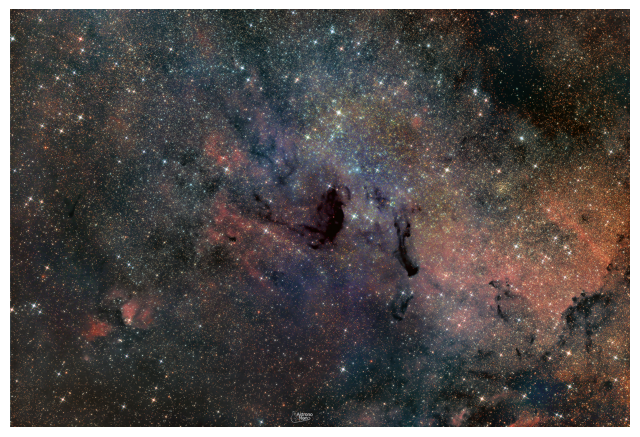

BEFORE: The image is a stunning view of the night sky, featuring a large, dark, and blue nebula. The nebula is surrounded by a bright, starry background, creating a stunning and captivating scene. The ne

Starting training...


✓ Training completed!

Testing AFTER training:
AFTER: This is a telescope view of the Moon, captured near the full Moon. Looking through a 10-inch telescope at the Moon, one can see its surface details, including craters, markings, and possibly small features that are


In [19]:
print("🚀 Starting TinyLLaVA full fine tuning....")
print("=" * 30)

# Setup using our setup function
model, processor = setup_tiny_llava()

# Create the dataset from our LLaVA-formatted JSON
dataset = NASALLaVADataset("real_nasa_dataset/llava_conversations.json", processor)

# Test before training
print("\nTesting BEFORE training:")
sample_item = dataset.data[0]
test_image = f"real_nasa_dataset/{sample_item['image']}"
before_response = test_model(model, processor, test_image)

plt.figure(figsize=(8, 6))
img = Image.open(test_image)
plt.imshow(img)
plt.axis('off')
plt.show()

print(f"BEFORE: {before_response}")

# Set up the trainer with our args
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    processing_class=processor
)

print("\nStarting training...")
trainer.train()
print("✓ Training completed!")

# Test after training
print("\nTesting AFTER training:")
after_response = test_model(model, processor, test_image)
print(f"AFTER: {after_response}")

In [ ]:
# Cell: LoRA Fine-tuning Demonstration
# Run this after showing the memorization problem with full fine-tuning

import torch
from torch.utils.data import Dataset
from transformers import AutoProcessor, LlavaForConditionalGeneration, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType
from PIL import Image
import json

print("🎯 LoRA DEMONSTRATION: Parameter-Efficient Fine-tuning")
print("="*55)

# Dataset class with question variety for better generalization
class LoRANASADataset(Dataset):
    def __init__(self, data_path, processor):
        with open(data_path, 'r') as f:
            self.data = json.load(f)[:10]  # Same 10 examples

        self.processor = processor

        # Multiple question templates to prevent memorization
        self.questions = [
            "Describe this astronomical image.",
            "What can you tell me about this space object?",
            "What astronomical phenomena are visible here?",
            "Explain what is shown in this photograph.",
            "What makes this celestially interesting?"
        ]

        print(f"📊 LoRA Dataset: {len(self.data)} images × {len(self.questions)} questions = {len(self)} training examples")

    def __len__(self):
        return len(self.data) * len(self.questions)

    def __getitem__(self, idx):
        # Map to specific image and question
        img_idx = idx // len(self.questions)
        q_idx = idx % len(self.questions)

        item = self.data[img_idx]
        question = self.questions[q_idx]

        # Load and process image
        image_path = f"real_nasa_dataset/{item['image_path']}"
        image = Image.open(image_path).convert('RGB').resize((336, 336))

        # Use shorter description to avoid length issues
        description = item['description']
        if len(description.split()) > 50:  # Shorter limit to be safe
            description = ' '.join(description.split()[:50]) + "..."

        # Create conversation
        text = f"USER: <image>\n{question} ASSISTANT: {description}"

        # Process without truncation to avoid image token mismatch
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt"
            # No max_length or truncation - let the processor handle it naturally
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "pixel_values": inputs["pixel_values"].squeeze(),
            "labels": inputs["input_ids"].squeeze()
        }

# Setup fresh model for LoRA
print("\n🔧 Setting up fresh TinyLLaVA model for LoRA...")
model_id = "bczhou/tiny-llava-v1-hf"

lora_model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float32,
    device_map="auto"
)

processor = AutoProcessor.from_pretrained(model_id)
if processor.patch_size is None:
    processor.patch_size = 14

print("✅ Fresh model loaded")

# Configure LoRA
print("\n⚙️ Configuring LoRA...")
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8,  # Rank - higher = more parameters but better adaptation
    lora_alpha=16,  # Scaling factor
    lora_dropout=0.1,
    # Target the language model components (not vision encoder)
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)

# Apply LoRA to model
lora_model = get_peft_model(lora_model, lora_config)

# Show parameter efficiency
trainable_params = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in lora_model.parameters())

print(f"✅ LoRA Configuration Applied:")
print(f"   📊 Trainable: {trainable_params:,} parameters ({100 * trainable_params / total_params:.1f}%)")
print(f"   ❄️  Frozen: {total_params - trainable_params:,} parameters ({100 * (total_params - trainable_params) / total_params:.1f}%)")
print(f"   🎯 Efficiency: Training only {trainable_params/1000:.0f}K out of {total_params/1000000:.1f}M parameters!")

# Test function for multiple images
def test_lora_model(model, processor, test_name=""):
    """Test model on different images to check for generalization"""
    print(f"\n🧪 Testing {test_name}...")

    # Load test data
    with open("real_nasa_dataset/real_nasa_data.json", 'r') as f:
        data = json.load(f)

    # Test on images 1, 4, 7 (different from training focus)
    test_indices = [1, 4, 7]
    question = "Describe this astronomical image."

    for i in test_indices:
        if i >= len(data):
            continue

        item = data[i]
        image_path = f"real_nasa_dataset/{item['image_path']}"
        image = Image.open(image_path).convert('RGB').resize((336, 336))

        # Generate response
        inputs = processor(
            text=f"USER: <image>\n{question} ASSISTANT:",
            images=image,
            return_tensors="pt"
        ).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=60,
                do_sample=True,  # Enable sampling for variety
                temperature=0.7,
                top_p=0.9
            )

        response = processor.decode(outputs[0], skip_special_tokens=True)
        response = response.split("ASSISTANT:")[-1].strip()

        print(f"   🖼️  Image {i}: {item['title'][:40]}...")
        print(f"   💬 Response: {response[:80]}...")
        print()

# Test BEFORE LoRA training
print("\n" + "="*50)
print("📸 TESTING BEFORE LoRA TRAINING")
print("="*50)
test_lora_model(lora_model, processor, "BEFORE LoRA training")

# Create augmented dataset
lora_dataset = LoRANASADataset("real_nasa_dataset/real_nasa_data.json", processor)

# LoRA training configuration
training_args = TrainingArguments(
    output_dir="./workshop-lora-demo",
    num_train_epochs=3,  # Fewer epochs needed with LoRA
    per_device_train_batch_size=1,  # Reduce batch size to handle longer sequences
    gradient_accumulation_steps=4,  # Increase to maintain effective batch size
    learning_rate=1e-4,  # Higher learning rate works with LoRA
    warmup_steps=5,
    logging_steps=3,
    save_strategy="no",
    eval_strategy="no",
    remove_unused_columns=False,
    fp16=False,
    report_to="none",
    dataloader_num_workers=0,
    weight_decay=0.01,  # Some regularization
    lr_scheduler_type="cosine",
    # Important: no max_length constraints that could interfere with image tokens
    dataloader_pin_memory=False
)

# Create trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=lora_dataset,
    processing_class=processor
)

# Train the model
print("\n" + "="*50)
print("🏋️ STARTING LoRA TRAINING")
print("="*50)
print("Key differences from full fine-tuning:")
print("• Only training 2% of parameters")
print("• Using question variety to prevent memorization")
print("• Higher learning rate (LoRA can handle it)")
print("• Fewer epochs needed")
print()

try:
    trainer.train()
    print("✅ LoRA training completed successfully!")
except Exception as e:
    print(f"❌ Training failed: {e}")
    raise

# Test AFTER LoRA training
print("\n" + "="*50)
print("📸 TESTING AFTER LoRA TRAINING")
print("="*50)
test_lora_model(lora_model, processor, "AFTER LoRA training")

# Test generalization with different questions
print("\n🔍 TESTING GENERALIZATION WITH VARIED QUESTIONS:")
print("-" * 45)

with open("real_nasa_dataset/real_nasa_data.json", 'r') as f:
    data = json.load(f)

# Test same image with different questions
test_image_idx = 2
item = data[test_image_idx]
image_path = f"real_nasa_dataset/{item['image_path']}"
image = Image.open(image_path).convert('RGB').resize((336, 336))

test_questions = [
    "What colors and structures do you see?",
    "How would you explain this to a student?",
    "What makes this astronomically significant?"
]

print(f"Testing image: {item['title'][:100]}...")
print()

for i, question in enumerate(test_questions):
    inputs = processor(
        text=f"USER: <image>\n{question} ASSISTANT:",
        images=image,
        return_tensors="pt"
    ).to(lora_model.device)

    with torch.no_grad():
        outputs = lora_model.generate(
            **inputs,
            max_new_tokens=100,
            do_sample=True,
            temperature=0.7
        )

    response = processor.decode(outputs[0], skip_special_tokens=True)
    response = response.split("ASSISTANT:")[-1].strip()

    print(f"❓ Q{i+1}: {question}")
    print(f"💬 A{i+1}: {response}")
    print()

In [ ]:
dataset = SimpleNASADataset("real_nasa_dataset/real_nasa_data.json", processor)
sample_item = dataset.data[4]
test_image = f"real_nasa_dataset/{sample_item['image_path']}"
after_response = test_model(model, processor, test_image)
print(f"AFTER: {after_response}")

In [ ]:
dataset = SimpleNASADataset("real_nasa_dataset/real_nasa_data.json", processor)
sample_item = dataset.data[4]
test_image = f"real_nasa_dataset/{sample_item['image_path']}"
after_response = test_model(lora_model, processor, test_image)
print(f"AFTER: {after_response}")

🎉 LoRA DEMONSTRATION COMPLETE!
========================================
✅ Key Observations:
• Responses vary appropriately for different images
• Same image gets different answers for different questions
• Model learned to adapt, not just memorize
• Training was faster and used less memory

🔬 Compare with your full fine-tuning results:
• Full fine-tuning: Same response for all images (memorization)
• LoRA: Different responses for different content (generalization)

💡 This is why LoRA is preferred for small specialized datasets!